**Make sure to include** `import allow_local_imports` on top of every notebook in `notebooks/` dir to be able to use `lib/` modules.

In [1]:
# Include this on top, as the first import 
# This must always be imported first. If you are restarting the notebook
# don't forget to run this cell first!
import allow_local_imports

In [2]:
from lib.minority_game import MinorityGame
from lib.agents.agent import Agent, StrategyUpdatingAgent
from lib.agents.factory import AgentFactory
from lib.strategies import AlwaysOneStrategy, DefaultStrategy, FiftyFiftyStrategy
from lib.memory import UniformMemoryGenerator
from lib.plots import default_plot

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma
import seaborn as sns
from numpy.random import default_rng

In [4]:
class BaseMemoryGenerator:
    """
    Abstract class that should be subclassed when implementing
    a new memory generator.
    """
    def __init__(self, m):
        self.m = m

    def generate(self, size):
        raise NotImplementedError


class UniformMemoryGenerator(BaseMemoryGenerator):
    """
    Samples memory from a uniform distribution.
    (All memories are of equal length...)
    """

    def generate(self, size):
        return np.ones(size, dtype=np.int32) * self.m
    
class NormalDistributionMemoryGenerator(BaseMemoryGenerator):
    """
    Samples memory from a distribution
    (Memories are distributed by normal distribution.)
    """

    def generate(self, size):
        rng = default_rng()
        return rng.normal(self.m, 0.5, size).astype(int)
    
class GaussianDistributionMemoryGenerator(BaseMemoryGenerator):
    """
    Samples memory from a distribution
    (Memories are distributed by default gaussian distribution.)
    """

    def generate(self, n_agents, min_m = 1, max_m = 20, a = 4):
        spaces = max_m-min_m+1
        x = np.linspace(min_m, max_m, spaces)
        y =  gamma.pdf(x, a)
        sample = np.random.choice(x, n_agents, p=y/(sum(y))).astype(int)
        return sample

class GumbelDistributionMemoryGenerator(BaseMemoryGenerator):
    """
    Samples memory from a gumbel distribution.
    (Skwed distribution of memory)
    """

    def generate(self, size):
        rng = default_rng()
        return rng.gumbel(self.m, 0.5, size).astype(int)   

## Simple MG (s = 2, N = 101, uniform memory)

In [5]:
n_agents = 101 # check with David why it does not work if I do MinorityGame.n_agents
tot_omega_u = []
tot_alpha_u = []

for M in range (2,10):
    times, attendances, mean_A_t, vol_A_t = MinorityGame(
        n_agents=101,
        factory_dict={
            1: AgentFactory(
                Agent,
                agent_kwargs=dict(
                    strategy_clss=[DefaultStrategy,DefaultStrategy]
                ),
                memory_generator=UniformMemoryGenerator(M)
            ),
        }
    ).simulate_game(max_steps=5000)
    # in order to create the graph
    omega = np.average(vol_A_t)/n_agents
    alpha = 2**M/n_agents
    tot_omega_u.append(omega)
    tot_alpha_u.append(alpha)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")
ax.plot(tot_alpha_u, tot_omega_u, 'bo')
ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility")

plt.title("Simple Minority Game with s=2, N=101")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.show()

## MG (s = 2, N = 101, gumbel distribution memory)

C:\Users\Reetta\Anaconda3\envs\abm-project\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


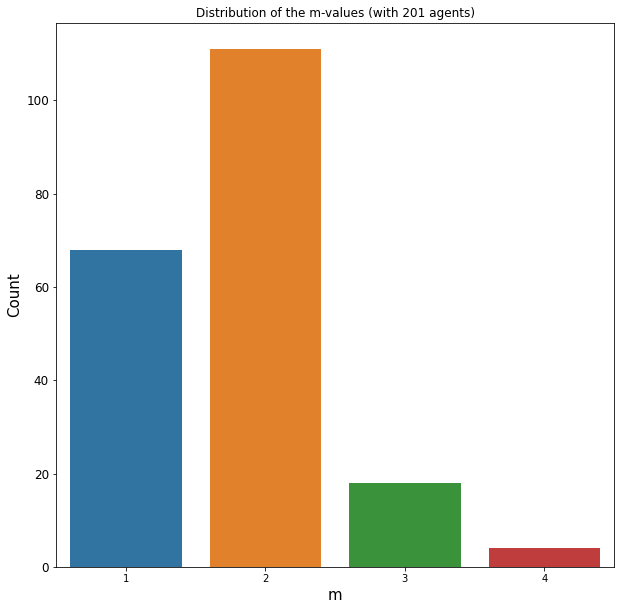

In [17]:
# a possible distribution 
%matplotlib inline
rng = default_rng()
m = 2
n_agents = 201

a = rng.gumbel(m, 0.5, n_agents).astype(int) # m is the mode , 1 is the scale (how narrow it is), n_agents is the size

# Numpy arrays containing counts for each side
side, count = np.unique(a, return_counts=True)
plt.figure(figsize=(10,10))

# Plot the results
sns.barplot(side, count)
plt.title(
    f"Distribution of the m-values (with {n_agents} agents)")
plt.ylabel("Count",fontsize=15)
plt.yticks(fontsize = 12)
plt.xlabel("m", fontsize=15)
plt.show()

In [7]:
n_agents = 101 
tot_omega_g = []
tot_alpha_g = []

for M in range (2,10):
    times, attendances, mean_A_t, vol_A_t = MinorityGame(
        n_agents=101,
        factory_dict={
            1: AgentFactory(
                Agent,
                agent_kwargs=dict(
                    strategy_clss=[DefaultStrategy,DefaultStrategy]
                ),
                memory_generator=GumbelDistributionMemoryGenerator(M)
            ),
        }
    ).simulate_game(max_steps=5000)
    # in order to create the graph
    omega = np.average(vol_A_t)/n_agents
    alpha = 2**M/n_agents
    tot_omega_g.append(omega)
    tot_alpha_g.append(alpha)

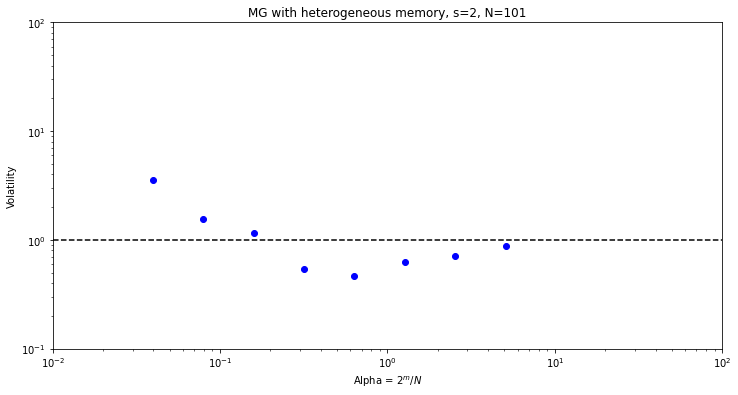

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")
ax.plot(tot_alpha_g, tot_omega_g, 'bo')
ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility")

plt.title("MG with heterogeneous memory, s=2, N=101")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.show()

## MG (s = 2, N = 101, normal distribution memory)

/Users/Luca/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


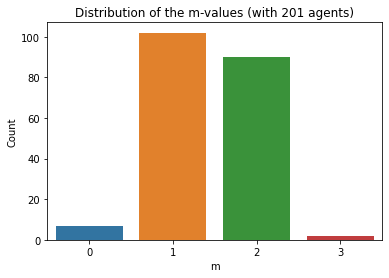

In [43]:
# problem it should not give 0 value
rng = default_rng()
m = 2
n_agents = 201

a = rng.normal(m, 0.5, n_agents).astype(int) # m is the mode , 1 is the scale (how narrow it is), n_agents is the size

# Numpy arrays containing counts for each side
side, count = np.unique(a, return_counts=True)

# Plot the results
sns.barplot(side, count)
plt.title(
    f"Distribution of the m-values (with {n_agents} agents)")
plt.ylabel("Count")
plt.xlabel("m")
plt.show()

In [21]:
n_agents = 101 # check with David why it does not work if I do MinorityGame.n_agents
tot_omega_n = []
tot_alpha_n = []

for M in range (3,10): # with 2 some agents have memory of 0 wich does not make sense
    times, attendances, mean_A_t, vol_A_t = MinorityGame(
        n_agents=101,
        factory_dict={
            1: AgentFactory(
                Agent,
                agent_kwargs=dict(
                    strategy_clss=[DefaultStrategy,DefaultStrategy]
                ),
                memory_generator=NormalDistributionMemoryGenerator(M)
            ),
        }
    ).simulate_game(max_steps=5000)
    # in order to create the graph
    omega = np.average(vol_A_t)/n_agents
    alpha = 2**M/n_agents
    tot_omega_n.append(omega)
    tot_alpha_n.append(alpha)

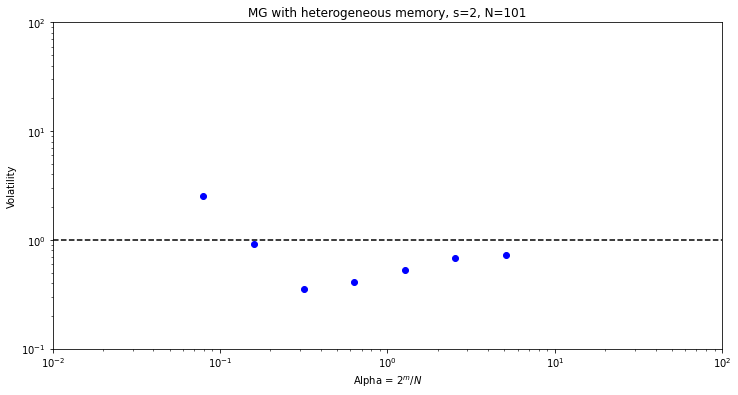

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")
ax.plot(tot_alpha_n, tot_omega_n, 'bo')
ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility")

plt.title("MG with heterogeneous memory, s=2, N=101")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.show()

## Everything in one graph

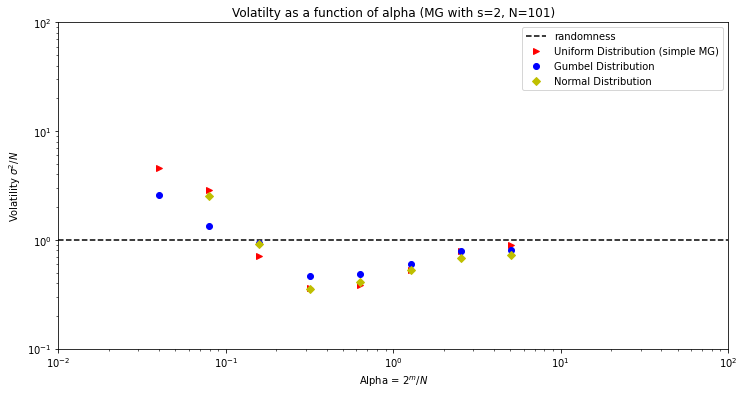

In [27]:
# everything in one graph

fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--") # vol = 1 -> randomness

ax.plot(tot_alpha_u, tot_omega_u, '>r')
ax.plot(tot_alpha_g, tot_omega_g, 'bo')
ax.plot(tot_alpha_n, tot_omega_n, 'Dy')

ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility $\sigma^2/N$")
ax.legend(["randomness","Uniform Distribution (simple MG)","Gumbel Distribution", "Normal Distribution"])

plt.title("Volatilty as a function of alpha (MG with s=2, N=101)")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.show()

## Check for variation in realization (should we do multiple realization for each value of alpha?)

In [36]:
# normal distribution

n_agents = 101 # check with David why it does not work if I do MinorityGame.n_agents
tot_omega = []
tot_alpha = []
realization = []
M = 5
for i in range (0,10): 
    times, attendances, mean_A_t, vol_A_t = MinorityGame(
        n_agents=101,
        factory_dict={
            1: AgentFactory(
                Agent,
                agent_kwargs=dict(
                    strategy_clss=[DefaultStrategy,DefaultStrategy]
                ),
                memory_generator=NormalDistributionMemoryGenerator(M)
            ),
        }
    ).simulate_game(max_steps=5000)
    # in order to create the graph
    omega = np.average(vol_A_t)/n_agents
    alpha = 2**M/n_agents
    tot_omega.append(omega)
    tot_alpha.append(alpha)
    realization.append(i)

In [40]:
realization

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

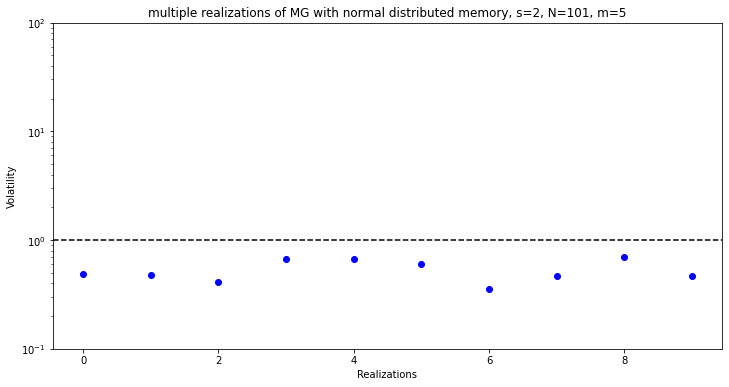

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")
ax.plot(realization, tot_omega, 'bo')
ax.set_xlabel("Realizations")
ax.set_ylabel("Volatility")

plt.title("multiple realizations of MG with normal distributed memory, s=2, N=101, m=5")
plt.yscale('log')
plt.ylim([0.1,100])

plt.show()

There is some variation within realizations...

## Individual agents

In [18]:
class NormalDistributionMemoryGenerator(BaseMemoryGenerator):
    """
    Samples memory from a distribution
    (Memories are distributed by normal distribution.)
    """
    def generate(self, size):
        rng = default_rng()
        return rng.normal(self.m, 2, size).astype(int)


class GumbelDistributionMemoryGenerator(BaseMemoryGenerator):
    """
    Samples memory from a gumbel distribution.
    (Skewed distribution of memory)
    """
    def generate(self, size):
        rng = default_rng()
        return rng.gumbel(self.m, 2, size).astype(int)   

In [19]:
import numpy as np
from numpy.lib.arraysetops import isin
from lib.error import MinorityGameError
from typing import List
import pandas as pd

In [20]:
import pdb; 

In [99]:
class MinorityGameIndividualAgents:
    """Base class for running a minority game (MG) simulation."""

    def __init__(self, n_agents: int, factory_dict, max_history=50, rng=None) -> None:
        """
        Args:
            n_agents (int): the number of agents `N`, must be odd
            factory_dict (dict): a dictionary that contains the AgentFactories,
                                 keys are the fractions of total_agents to produce
                                 from the AgentFactories
            max_history (int): the maximum history that will be kept in the game memory
            rng (Generator): the random number generator used in the game
        """
        if n_agents % 2 == 0:
            raise MinorityGameError("Number of agents should be odd")
        self.n_agents = n_agents

        # Random Number Generator
        self.rng = rng or np.random.default_rng()

        # Agents
        total_agent_frac = np.sum(list(factory_dict.keys()))
        if total_agent_frac != 1:
            raise MinorityGameError(
                f"The sum of agent fractions must be equal to 1 (current value = {total_agent_frac})"
            )

        agents = []
        for agent_frac, factory in factory_dict.items():
            n_new_agents = int(n_agents * agent_frac)
            new_agents = factory.create_agents(n_new_agents, self.rng)
            agents += new_agents
        self.agents = agents

        # Max history amount
        self.MAX_HISTORY = max_history

        self._reset_game_state()

    def _reset_agents_strategies(self):
        """Reset the strategies of each agent."""
        for agent in self.agents:
            agent.reset_strategies()

    def _reset_game_state(self):
        """
        Resets the agents history (current memory of each agent), strategies
        and strategy scores.
        """
        self.history = 2*self.rng.integers(2, size=self.MAX_HISTORY)-1

        self._reset_agents_strategies()

        for agent in self.agents:
            agent.reset_strategy_scores()

    def _update_scores_and_history(self, A_t: int, actions: List[int]):
        """
        Compute the round winner, update history and strategy scores for each
        agent by mu_t

        Args:
            A_t (int): the attendance (sum of actions of each agent)
            mu_t (int): number whose binary representation encodes the current
                        history, used to index the agent's strategy
        """
        # Get the minority (round winner)
        round_winner = -1 if A_t > 0 else 1

        # For each agent update his strategy scores
        for i, agent in enumerate(self.agents):
            agent_action = actions[i]
            agent.update_scores(
                round_winner,
                agent_action,
                self.history
            )

        # Update history
        # Roll the current history to the left by one
        # [1, -1, 1] -> [-1, 1, 1]
        self.history = np.roll(self.history, -1)
        # Replace the last element with the current round winner
        self.history[-1] = round_winner

    def _game_step(self):
        """Runs a simulation of one round of MG."""
        # The actions of each agent during this round
        actions = np.zeros(self.n_agents)

        # Find the best performing strategy of each agent
        # by their strategy score and determine the action
        # they want to take based on the game memory (history)
        m_list = []
        for i, agent in enumerate(self.agents):
            a_t = agent.choose_action(self.history)
            actions[i] = a_t
            m_list.append(agent.m)
            

        # Get the attendance / sum of all actions
        A_t = np.sum(actions)

        # Update scores and history accordingly
        self._update_scores_and_history(A_t, actions)

        return A_t, actions, m_list, 

    def volatility(self, A_t):
        """Compute the volatility / variance of A_t

        Args:
            A_t (np.array): a 1D array containing A_t values over
                            multiple repetitions / time
        """
        return A_t.var()

    def total_success_rate(self, agent_cls=None):
        """
        Compute total success rate by taking the mean of success
        rates of each agent.

        Args:
            agent_cls: the filter class to use while computing
                       the total success rate. If None is used
                       (default) the success rate is computed as
                       the average between all agents.
        """
        succes_rates = np.zeros(len(self.agents))
        for i, agent in enumerate(self.agents):
            if agent_cls is not None:
                if not isinstance(agent, agent_cls):
                    continue
            succes_rates[i] = agent.success_rate()
        return succes_rates.mean()

    def simulate_game(self, max_steps=500):
        """Simulate a Minority Game

        Args:
            max_steps (int): the maximum number of time steps this game is
                             allowed to run for

        Returns:
            times (np.array): 1D array of timesteps, useful for plotting
            attendances (np.array): 1D array of A_t for each time step
            mean_A_t (np.array): 1D array of mean A_t over time
            vol_A_t (np.array): 1D array of the variance of A_t over time
        """
        self._reset_game_state()

        times, attendances, mean_A_t, vol_A_t, = np.zeros((4, max_steps))
        times_list = []
        
        mean_A_t_individual_m = []
        vol_A_t_individual_m = []
        actions_list = []
        
        A_t_table_list = pd.DataFrame()
        A_t_table_list["index"] = ""

        # Run the game
        for t in range(max_steps):
            A_t, actions, m_list = self._game_step()
            actions_list.append(actions)
            
            # Save for plotting
            times[t] = t
            attendances[t] = A_t            
        
            # Take only the first t+1 attendances to avoid
            # averaging over the entire max_steps
            
            attendances_until_now = attendances[t]
            
            mean_A_t[t] = attendances_until_now.mean()
            vol_A_t[t] = self.volatility(attendances_until_now)
            pdb.set_trace()
            
        # Make the actions into a data frame with m as rows and columns repeats
        actions_table = pd.DataFrame(actions_list, columns = m_list).transpose()
        actions_table.reset_index(inplace=True)
        # Tables for the action sums and the number of agents for each m
        A_t_table = actions_table.groupby(by=["index"]).sum().transpose()
        A_t_table = pd.DataFrame(A_t_table)
        
        # Count the number of agents for each m, (they are the same for each round so we can just take one) 
        n_agents_m = actions_table.groupby('index')['index'].agg(['count'])
        n_agents_m.reset_index(inplace = True)
        
        #Take the splits necessary
#         for t in range(max_steps):
#             A_t_table_until_now = A_t_table
#             pdb.set_trace()
#             A_t_table_until_now = A_t_table_until_now[:t+1]#the first row is the m-values
            
#             mean_A_t_individual_m.append(A_t_table_until_now.mean())
#             vol_A_t_individual_m.append(A_t_table_until_now.var())
                        
#             mean_A_t_individual_m_df = pd.DataFrame(mean_A_t_individual_m)
#             vol_A_t_individual_m_df = pd.DataFrame(vol_A_t_individual_m)

        mean_A_t_individual_m_df = A_t_table.mean()
        vol_A_t_individual_m_df = A_t_table.var()

        return times, attendances, vol_A_t, n_agents_m, m_list, vol_A_t_individual_m_df 


In [ ]:
%%time
n_agents = 101
tot_omega_u_orig = []
tot_alpha_u_orig = []
M = 7
times, attendances, vol_A_t, n_agents_m, m_list, vol_A_t_individual_m_df = MinorityGameIndividualAgents(
    n_agents=101,
    factory_dict={
        1: AgentFactory(
            Agent,
            agent_kwargs=dict(
                strategy_clss=[DefaultStrategy,DefaultStrategy]
            ),
            memory_generator=UniformMemoryGenerator(M)
        ),
    }
).simulate_game(max_steps=100)
# in order to create the graph
omega = np.average(vol_A_t)/n_agents
alpha = 2**M/n_agents
tot_omega_u_orig.append(omega)
tot_alpha_u_orig.append(alpha)

tot_omega_u = np.average(vol_A_t_individual_m_df)/n_agents_m['count']
tot_alpha_u =  2**n_agents_m['index']/n_agents_m['count']

> <ipython-input-99-94732c234f23>(163)simulate_game()
    161 
    162         # Run the game
--> 163         for t in range(max_steps):
    164             A_t, actions, m_list = self._game_step()
    165             actions_list.append(actions)

ipdb> attendances
array([13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
ipdb> n
> <ipython-input-99-94732c234f23>(164)simulate_game()
    162         # Run the game
    163         for t in range(max_steps):
--> 164             A_t, actions, m_list 

array([ -7.,  -5.,  -9.,  -3.,   1.,   3., -17.,  -9.,   1.,   3., -17.,
         7.,   7., -13.,  -1.,  -7.,   1.,  -9.,  15.,  -1.,   5., -13.,
        -5.,  -7.,   1.,  19.,   1.,  -7., -31., -13.,  -1.,  11.,  15.,
       -11.,  -5.,   1.,  -3., -11.,   9.,  -3.,  -1.,  -9.,   5.,  -3.,
        -7.,  -3.,  -5.,   5., -15.,   7.,  -1.,  -7.,   1.,  -5.,  -1.,
        -3.,  -5.,   1.,   7.,  15.,   5.,  11.,  19.,  -9.,  15.,   7.,
         5.,   5.,  13.,   1.,   3.,   3., -11.,  -3.,  17.,  -7.,  -5.,
        -7.,  -1., -11.,  -1.,  -5.,  23.,  -7., -15.,   1.,  21., -15.,
        -5.,  11.,  21.,   1., -11.,  -1.,   1.,   1.,   3.,  -1.,   5.,
        17.])
ipdb> t
*** NameError: name 't' is not defined
ipdb> s
> <ipython-input-99-94732c234f23>(96)_game_step()
     94         m_list = []
     95         for i, agent in enumerate(self.agents):
---> 96             a_t = agent.choose_action(self.history)
     97             actions[i] = a_t
     98             m_list.append(agent.m)


In [96]:
vol_A_t

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [93]:
tot_alpha_u_orig

[1.2673267326732673]

In [94]:
tot_omega_u

0    0.915848
Name: count, dtype: float64

In [95]:
tot_alpha_u

0    1.267327
dtype: float64

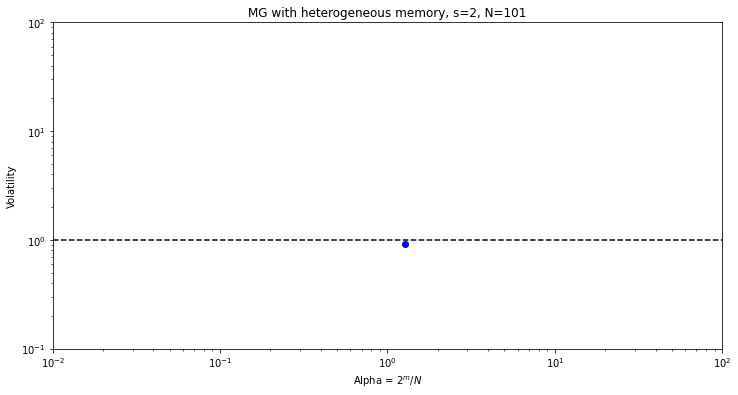

In [89]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")

ax.plot(tot_alpha_u, tot_omega_u, 'bo')
ax.plot(tot_alpha_u_orig, tot_omega_u_orig, '>r')

ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility")

plt.title("MG with heterogeneous memory, s=2, N=101")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.show()

In [25]:
%%time
n_agents = 101
tot_omega_u_orig = []
tot_alpha_u_orig = []
M = 7
times, attendances, vol_A_t, n_agents_m, m_list, vol_A_t_individual_m_df = MinorityGameIndividualAgents(
    n_agents=101,
    factory_dict={
        1: AgentFactory(
            Agent,
            agent_kwargs=dict(
                strategy_clss=[DefaultStrategy,DefaultStrategy]
            ),
            memory_generator=NormalDistributionMemoryGenerator(M)
        ),
    }
).simulate_game(max_steps=100)
# in order to create the graph
omega = np.average(vol_A_t)/n_agents
alpha = 2**M/n_agents
tot_omega_u_orig.append(omega)
tot_alpha_u_orig.append(alpha)

tot_omega_n = np.average(vol_A_t_individual_m_df)/n_agents_m['count']
tot_alpha_n =  2**n_agents_m['index']/n_agents_m['count']

Wall time: 5.56 s


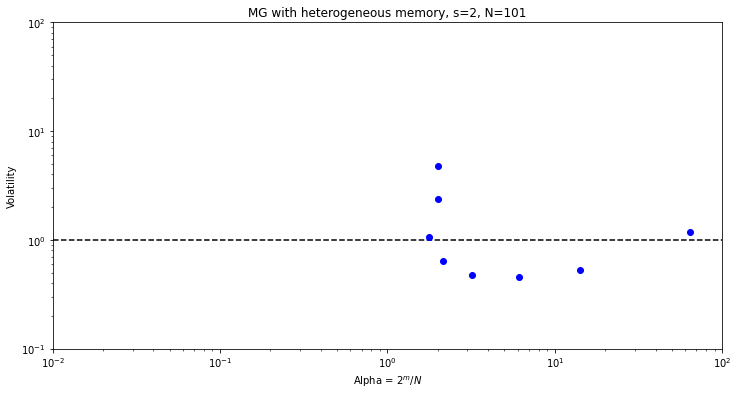

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")
ax.plot(tot_alpha_n, tot_omega_n, 'bo')
ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility")

plt.title("MG with heterogeneous memory, s=2, N=101")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.show()

In [35]:
%%time
n_agents = 101 
M = 7
max_steps = 100

# Gumbel distribution
times, attendances, vol_A_t, n_agents_m, m_list, vol_A_t_individual_m_df = MinorityGameIndividualAgents(
    n_agents=101,
    factory_dict={
        1: AgentFactory(
            Agent,
            agent_kwargs=dict(
                strategy_clss=[DefaultStrategy,DefaultStrategy]
            ),
            memory_generator=GumbelDistributionMemoryGenerator(M)
        ),
    }
).simulate_game(max_steps=max_steps)
m_list_g = n_agents_m['index']
tot_omega_g = np.average(vol_A_t_individual_m_df)/n_agents_m['count']
tot_alpha_g =  2**m_list_g/n_agents_m['count']

#Normal distribution
times, attendances, vol_A_t, n_agents_m, m_list, vol_A_t_individual_m_df = MinorityGameIndividualAgents(
    n_agents=101,
    factory_dict={
        1: AgentFactory(
            Agent,
            agent_kwargs=dict(
                strategy_clss=[DefaultStrategy,DefaultStrategy]
            ),
            memory_generator=NormalDistributionMemoryGenerator(M)
        ),
    }
).simulate_game(max_steps=max_steps)
m_list_n = n_agents_m['index']
tot_omega_n = np.average(vol_A_t_individual_m_df)/n_agents_m['count']
tot_alpha_n =  2**m_list_n/n_agents_m['count']

# Uniform distribution (from the standard minority game class to compare)
tot_omega_u = []
tot_alpha_u = []
m_list_u = []
for M in range (2,15):
    times, attendances, mean_A_t, vol_A_t = MinorityGame(
        n_agents=n_agents,
        factory_dict={
            1: AgentFactory(
                Agent,
                agent_kwargs=dict(
                    strategy_clss=[DefaultStrategy,DefaultStrategy]
                ),
                memory_generator=UniformMemoryGenerator(M)
            ),
        }
    ).simulate_game(max_steps=max_steps)
    m_list_u.append(M)
    omega = np.average(vol_A_t)/n_agents
    alpha = 2**M/n_agents
    tot_omega_u.append(omega)
    tot_alpha_u.append(alpha)

Wall time: 39.1 s


m instead of alpha

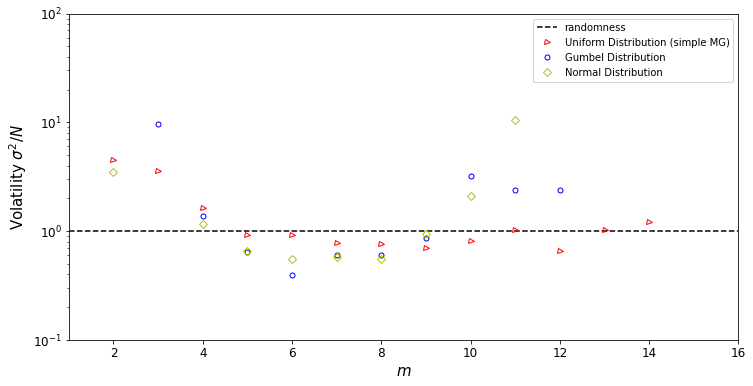

In [39]:


fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--") # vol = 1 -> randomness


ax.plot(m_list_u, tot_omega_u, 'r>', mfc = 'None', ms = 5)
ax.plot(m_list_g, tot_omega_g, 'bo', mfc = 'None', ms = 5)
ax.plot(m_list_n, tot_omega_n, 'Dy', mfc = 'None', ms = 5)

plt.ylabel("Volatility $\sigma^2/N$",fontsize=15)
plt.xlabel("$m$",fontsize=15)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

# ax.set_xlabel("m")
# ax.set_ylabel("Volatility $\sigma^2/N$")
ax.legend(["randomness","Uniform Distribution (simple MG)","Gumbel Distribution", "Normal Distribution"])

plt.yscale('log')
plt.xlim([1,16])
plt.ylim([0.1,100])
plt.savefig('out/distributionIndividualM_empty.png', dpi=300, bbox_inches='tight')

plt.show()

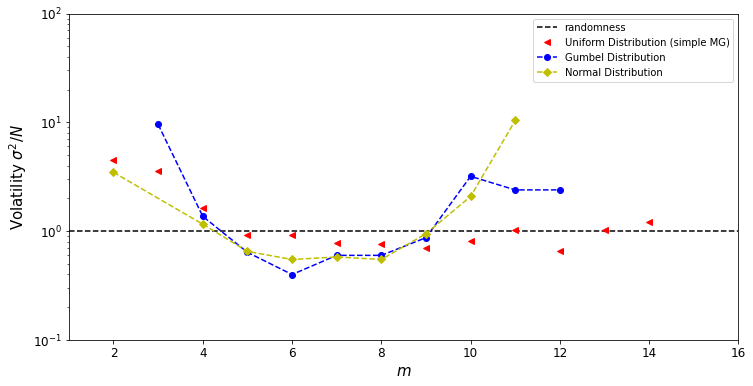

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--") # vol = 1 -> randomness


ax.plot(m_list_u, tot_omega_u, 'r<')
ax.plot(m_list_g, tot_omega_g, 'bo', linestyle="--")
ax.plot(m_list_n, tot_omega_n, 'Dy', linestyle="--")

# ax.set_xlabel("m")
# ax.set_ylabel("Volatility $\sigma^2/N$")
ax.legend(["randomness","Uniform Distribution (simple MG)","Gumbel Distribution", "Normal Distribution"])

plt.ylabel("Volatility $\sigma^2/N$",fontsize=15)
plt.xlabel("$m$",fontsize=15)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

plt.yscale('log')
plt.xlim([1,16])
plt.ylim([0.1,100])
plt.savefig('out/distributionIndividualM.png', dpi=300, bbox_inches='tight')

plt.show()

alpha

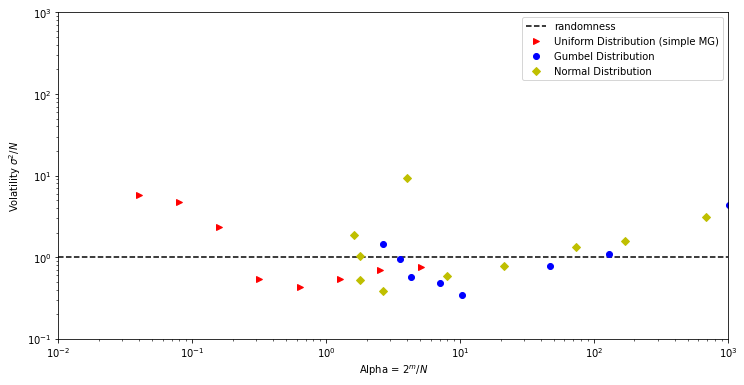

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--") # vol = 1 -> randomness

ax.plot(tot_alpha_u, tot_omega_u, '>r')
ax.plot(tot_alpha_g, tot_omega_g, 'bo')
ax.plot(tot_alpha_n, tot_omega_n, 'Dy')

ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility $\sigma^2/N$")
ax.legend(["randomness","Uniform Distribution (simple MG)","Gumbel Distribution", "Normal Distribution"])

plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,1000])
plt.ylim([0.1,1000])
plt.savefig('out/distributionIndividualM_alpha.png', dpi=300, bbox_inches='tight')

plt.show()